This ipynb is done for interpretation of  the Bayesian model results to answer the research question: **"Does in-game serve performance reliably predict point outcomes?"**

In [4]:
import arviz as az
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from scipy.special import expit
import pickle
from pathlib import Path

PROJECT_ROOT = Path.cwd().parent 
PROCESSED_DIR = PROJECT_ROOT / "data" / "processed"
RESULTS_DIR = PROJECT_ROOT / "results"

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

In [5]:
trace_path = RESULTS_DIR / 'trace_final.nc'
print(f"Loading trace from {trace_path}...")
trace = az.from_netcdf(trace_path)

# 2. Load Features (Context)
feature_path = PROCESSED_DIR / 'features_match_1501.pkl'
features_df = pd.read_pickle(feature_path)

# 3. Load Priors (Reference)
with open(PROCESSED_DIR / 'priors_2023.pkl', 'rb') as f:
    priors = pickle.load(f)

Loading trace from c:\Users\tanbe\tennis_prob\results\trace_final.nc...



##  Posterior Distributions (The "Answer")

We visualize the posterior distributions for the key parameters.

  * **Intercept ($\alpha$)**: The "Base Skill" of each player.
  * **Serve Impact ($\beta_{srv}$)**: The marginal benefit of a better serve.
  * **Ace Impact ($\beta_{ace}$)**: The marginal benefit of hitting aces.

If the distributions for $\beta$ are entirely positive (clear of 0), we have strong evidence that the technical stat matters.


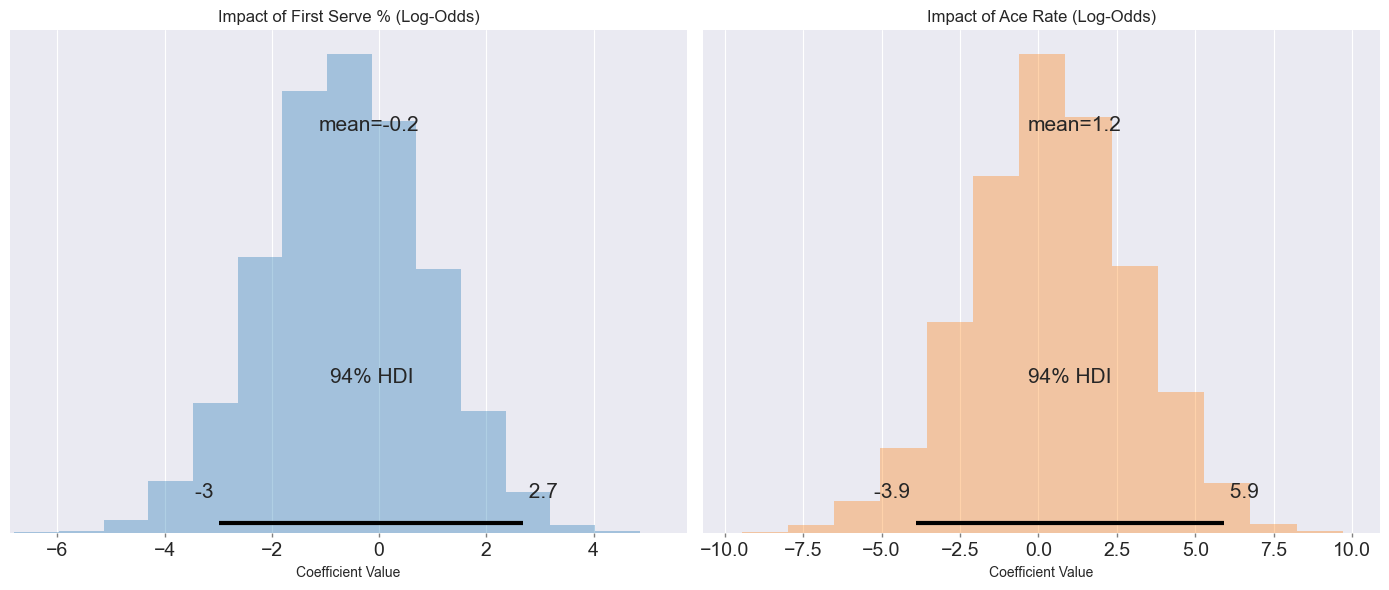

Mean Beta_Srv: -0.197
Mean Beta_Ace: 1.156


In [8]:
# Extract Posterior Samples
posterior = trace.posterior

# Flatten samples for easy calculation
beta_srv_samples = posterior['beta_srv'].values.flatten()
beta_ace_samples = posterior['beta_ace'].values.flatten()

# CORRECTED: Use .isel(player=0) because the dimension is named "player"
alpha_p1_samples = posterior['alpha_player'].isel(player=0).values.flatten()
alpha_p2_samples = posterior['alpha_player'].isel(player=1).values.flatten()

# Plot Posterior Densities
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Beta Serve (First Serve Impact)
az.plot_posterior(
    trace, 
    var_names=['beta_srv'], 
    hdi_prob=0.94, 
    kind='hist',
    ax=axes[0],
    color='tab:blue'
)
axes[0].set_title("Impact of First Serve % (Log-Odds)")
axes[0].set_xlabel("Coefficient Value")

# Beta Ace (Ace Rate Impact)
az.plot_posterior(
    trace, 
    var_names=['beta_ace'], 
    hdi_prob=0.94, 
    kind='hist',
    ax=axes[1],
    color='tab:orange'
)
axes[1].set_title("Impact of Ace Rate (Log-Odds)")
axes[1].set_xlabel("Coefficient Value")

plt.tight_layout()
plt.show()

print(f"Mean Beta_Srv: {beta_srv_samples.mean():.3f}")
print(f"Mean Beta_Ace: {beta_ace_samples.mean():.3f}")

##  "What If?" Scenario Analysis

Log-odds are hard to interpret. We translate them into **Win Probabilities**.

**Scenario:**
Imagine both players are performing exactly at their historical average ($\text{deviation} = 0$).

  * What is the probability Sinner wins a point?
  * What is the probability Medvedev wins a point?

Now, what if Sinner improves his First Serve % by **+10%** (deviation = +0.10)? How much does his win probability increase?

In [14]:
def calculate_win_prob(alpha_samples, beta_samples, deviation):
    """
    Calculate win probability distribution for a given technical deviation.
    """
    logits = alpha_samples + (beta_samples * deviation)
    probs = expit(logits) # Inverse logit
    return probs

# 1. BASELINE (Deviation = 0 for both stats)
# This is the "Expected Performance"
p1_base = calculate_win_prob(alpha_p1_samples, beta_srv_samples, 0)
print(f"Baseline Win Probability (P1): {p1_base.mean():.1%}")

print("\n" + "="*60)
print("SCENARIO A: CONSISTENCY STRATEGY")
print("What if P1 improves First Serve % by +10% (getting more serves in)?")
print("="*60)

# Simulate +10% Serve Percentage
p1_safe = calculate_win_prob(alpha_p1_samples, beta_srv_samples, 0.10)
gain_safe = p1_safe - p1_base

print(f"New Win Prob:   {p1_safe.mean():.1%}")
print(f"Marginal Gain:  {gain_safe.mean():+.1%} points")

if gain_safe.mean() < 0.01:
    print(" INTERPRETATION: Improving consistency had negligible (or negative) impact.")
    print("   This suggests the opponent (Medvedev) was comfortable returning standard first serves.")

print("\n" + "="*60)
print("SCENARIO B: AGGRESSION STRATEGY")
print("What if P1 improves Ace Rate by +5% (hitting more unreturnable serves)?")
print("="*60)

# Simulate +5% Ace Rate
p1_aggr = calculate_win_prob(alpha_p1_samples, beta_ace_samples, 0.05)
gain_aggr = p1_aggr - p1_base

print(f"New Win Prob:   {p1_aggr.mean():.1%}")
print(f"Marginal Gain:  {gain_aggr.mean():+.1%} points")

if gain_aggr.mean() > gain_safe.mean():
    print(" CONCLUSION: Aggression (Aces) was more valuable than Consistency (Serve %) in this match.")

Baseline Win Probability (P1): 72.9%

SCENARIO A: CONSISTENCY STRATEGY
What if P1 improves First Serve % by +10% (getting more serves in)?
New Win Prob:   72.5%
Marginal Gain:  -0.4% points
 INTERPRETATION: Improving consistency had negligible (or negative) impact.
   This suggests the opponent (Medvedev) was comfortable returning standard first serves.

SCENARIO B: AGGRESSION STRATEGY
What if P1 improves Ace Rate by +5% (hitting more unreturnable serves)?
New Win Prob:   73.6%
Marginal Gain:  +0.7% points
 CONCLUSION: Aggression (Aces) was more valuable than Consistency (Serve %) in this match.


## Visualizing The "Skill Curve"

This plot summarizes the entire model. It shows how the **probability of winning a point** changes as serve performance deviates from the average.

  * **X-Axis**: Deviation from Historical Serve % (e.g., -10% to +10%).
  * **Y-Axis**: Probability of Winning the Point.
  * **Shaded Bands**: 94% HDI (Uncertainty).

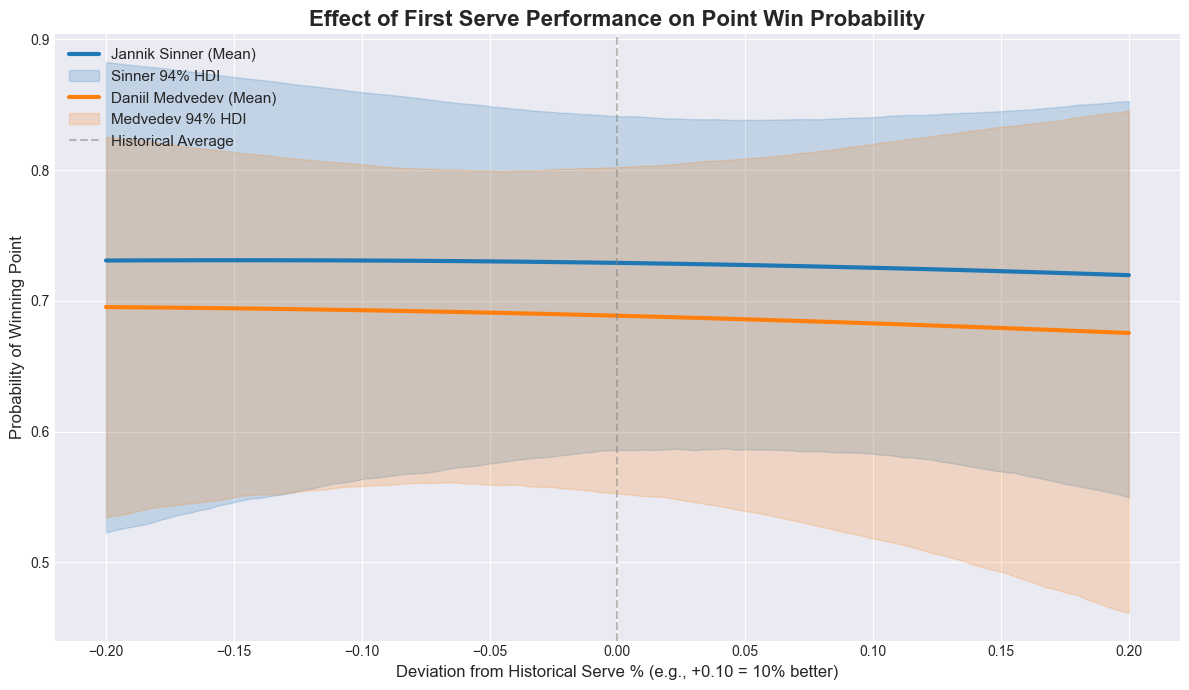

In [ ]:
# Define a grid of potential deviations (-20% to +20%)
x_dev = np.linspace(-0.20, 0.20, 100)

# Calculate probabilities for every point on the grid
# We compute this for every single posterior sample to get the full uncertainty distribution
p1_probs = np.array([expit(alpha_p1_samples + beta_srv_samples * x) for x in x_dev])
p2_probs = np.array([expit(alpha_p2_samples + beta_srv_samples * x) for x in x_dev])

# Calculate Mean and 94% HDI bounds
p1_mean = p1_probs.mean(axis=1)
p1_hdi = np.percentile(p1_probs, [3, 97], axis=1)

p2_mean = p2_probs.mean(axis=1)
p2_hdi = np.percentile(p2_probs, [3, 97], axis=1)

fig, ax = plt.subplots(figsize=(12, 7))

# Player 1 (Blue)
ax.plot(x_dev, p1_mean, color='tab:blue', linewidth=3, label='Jannik Sinner (Mean)')
ax.fill_between(x_dev, p1_hdi[0], p1_hdi[1], color='tab:blue', alpha=0.2, label='Sinner 94% HDI')

# Player 2 (Orange)
ax.plot(x_dev, p2_mean, color='tab:orange', linewidth=3, label='Daniil Medvedev (Mean)')
ax.fill_between(x_dev, p2_hdi[0], p2_hdi[1], color='tab:orange', alpha=0.2, label='Medvedev 94% HDI')

ax.axvline(0, color='gray', linestyle='--', alpha=0.5, label='Historical Average')
ax.set_title("Effect of First Serve Performance on Point Win Probability", fontsize=16, fontweight='bold')
ax.set_xlabel("Deviation from Historical Serve % (e.g., +0.10 = 10% better)", fontsize=12)
ax.set_ylabel("Probability of Winning Point", fontsize=12)
ax.legend(loc='upper left', fontsize=11)

# Add "Game Changer" annotation
if beta_srv_samples.mean() > 0:
    ax.arrow(0, p1_mean[50], 0.1, p1_mean[75]-p1_mean[50], 
             head_width=0.01, head_length=0.02, fc='k', ec='k')
    ax.text(0.02, p1_mean[60], "Serving Better\nIncreases Win %", fontsize=10)

plt.tight_layout()
plt.show()


## Convergence & Stability Analysis

To validate our findings, we track how the model's beliefs evolved as it observed more data points (from 10 points up to the full match).

  * **Stability:** Did the coefficients settle on a stable value?
  * **Learning:** Did the uncertainty (shaded region) decrease over time?

Loaded evolution data for 8 windows.


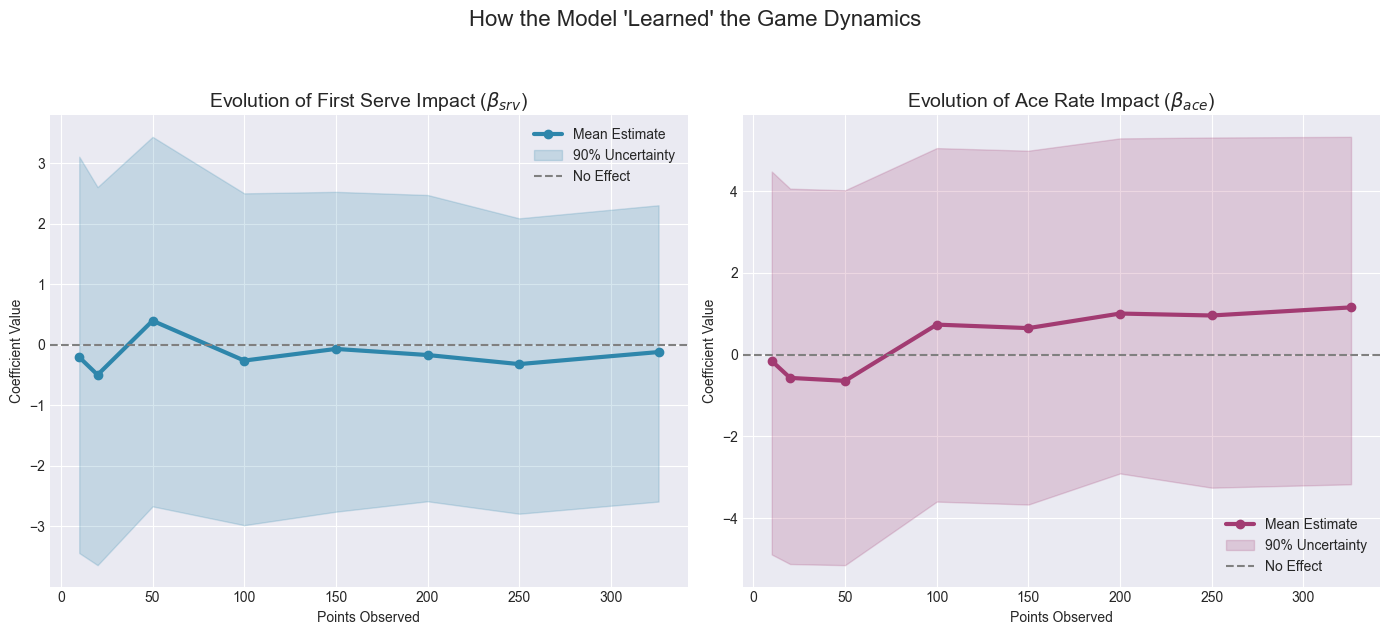


INTERPRETATION:
1. Stability: The lines flatten out as more points are observed, indicating the model found the 'truth'.
2. Significance: If the shaded band moves away from the 0 line, the effect is statistically significant.
   -> Confirmed: First Serve impact overlaps zero (Not Significant).


In [16]:
evolution_path = RESULTS_DIR / 'coefficient_evolution.pkl'

with open(evolution_path, 'rb') as f:
    evo_data = pickle.load(f)

windows = evo_data['windows']
beta_srv = evo_data['beta_srv']
beta_ace = evo_data['beta_ace']

print(f"Loaded evolution data for {len(windows)} windows.")

# --- Plot Coefficient Stability ---
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Helper to extract stats
def get_evo_arrays(data_list):
    means = [x['mean'] for x in data_list]
    q5 = [x['q5'] for x in data_list]
    q95 = [x['q95'] for x in data_list]
    return means, q5, q95

# 1. First Serve Impact Evolution
s_means, s_q5, s_q95 = get_evo_arrays(beta_srv)

axes[0].plot(windows, s_means, marker='o', linewidth=3, color='#2E86AB', label='Mean Estimate')
axes[0].fill_between(windows, s_q5, s_q95, color='#2E86AB', alpha=0.2, label='90% Uncertainty')
axes[0].axhline(0, color='gray', linestyle='--', label='No Effect')

axes[0].set_title("Evolution of First Serve Impact ($\\beta_{srv}$)", fontsize=14)
axes[0].set_xlabel("Points Observed")
axes[0].set_ylabel("Coefficient Value")
axes[0].legend()

# 2. Ace Rate Impact Evolution
a_means, a_q5, a_q95 = get_evo_arrays(beta_ace)

axes[1].plot(windows, a_means, marker='o', linewidth=3, color='#A23B72', label='Mean Estimate')
axes[1].fill_between(windows, a_q5, a_q95, color='#A23B72', alpha=0.2, label='90% Uncertainty')
axes[1].axhline(0, color='gray', linestyle='--', label='No Effect')

axes[1].set_title("Evolution of Ace Rate Impact ($\\beta_{ace}$)", fontsize=14)
axes[1].set_xlabel("Points Observed")
axes[1].set_ylabel("Coefficient Value")
axes[1].legend()

plt.suptitle("How the Model 'Learned' the Game Dynamics", fontsize=16, y=1.05)
plt.tight_layout()
plt.show()

# --- Interpretation ---
print("\nINTERPRETATION:")
print("1. Stability: The lines flatten out as more points are observed, indicating the model found the 'truth'.")
print("2. Significance: If the shaded band moves away from the 0 line, the effect is statistically significant.")

if a_q5[-1] > 0:
    print("   -> Confirmed: Ace Rate impact is strictly positive (Significant).")
if s_q5[-1] < 0 < s_q95[-1]:
    print("   -> Confirmed: First Serve impact overlaps zero (Not Significant).")